## **Problem Statement**

### Business Context

The prices of the stocks of companies listed under a global exchange are influenced by a variety of factors, with the company's financial performance, innovations and collaborations, and market sentiment being factors that play a significant role. News and media reports can rapidly affect investor perceptions and, consequently, stock prices in the highly competitive financial industry. With the sheer volume of news and opinions from a wide variety of sources, investors and financial analysts often struggle to stay updated and accurately interpret its impact on the market. As a result, investment firms need sophisticated tools to analyze market sentiment and integrate this information into their investment strategies.

### Problem Definition

With an ever-rising number of news articles and opinions, an investment startup aims to leverage artificial intelligence to address the challenge of interpreting stock-related news and its impact on stock prices. They have collected historical daily news for a specific company listed under NASDAQ, along with data on its daily stock price and trade volumes.

As a member of the Data Science and AI team in the startup, you have been tasked with developing an AI-driven sentiment analysis system that will automatically process and analyze news articles to gauge market sentiment, and summarizing the news at a weekly level to enhance the accuracy of their stock price predictions and optimize investment strategies. This will empower their financial analysts with actionable insights, leading to more informed investment decisions and improved client outcomes.

### Data Dictionary

* `Date` : The date the news was released
* `News` : The content of news articles that could potentially affect the company's stock price
* `Open` : The stock price (in \$) at the beginning of the day
* `High` : The highest stock price (in \$) reached during the day
* `Low` :  The lowest stock price (in \$) reached during the day
* `Close` : The adjusted stock price (in \$) at the end of the day
* `Volume` : The number of shares traded during the day
* `Label` : The sentiment polarity of the news content
    * 1: positive
    * 0: neutral
    * -1: negative

## **Installing and Importing the necessary libraries**

In [1]:
# installing the sentence-transformers and gensim libraries for word embeddings
!pip install numpy==1.26.4 \
             scikit-learn==1.6.1 \
             scipy==1.13.1 \
             gensim==4.3.3 \
             sentence-transformers==3.4.1 \
             pandas==2.2.2

Note:
- After running the above cell, kindly restart the runtime (for Google Colab) or notebook kernel (for Jupyter Notebook), and run all cells sequentially from the next cell.
- On executing the above line of code, you might see a warning regarding package dependencies. This error message can be ignored as the above code ensures that all necessary libraries and their dependencies are maintained to successfully execute the code in this notebook.

In [3]:
# to read and manipulate the data
import numpy as np
import pandas as pd
pd.set_option('max_colwidth', None)    # setting column to the maximum column width as per the data

# to visualise data
import matplotlib.pyplot as plt
import seaborn as sns

# To import Word2Vec
from gensim.models import Word2Vec

# Deep Learning library
import torch

# to load transformer models
from sentence_transformers import SentenceTransformer
from transformers import T5Tokenizer, T5ForConditionalGeneration, pipeline

# To split data into train and test sets
from sklearn.model_selection import train_test_split

# To build a Random Forest model
from sklearn.ensemble import RandomForestClassifier

# To compute metrics to evaluate the model
from sklearn.metrics import accuracy_score, confusion_matrix

# to ignore unnecessary warnings
import warnings
warnings.filterwarnings("ignore")

# Import TensorFlow and Keras for deep learning model building.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

## **Loading the dataset**

In [4]:
# Load the dataset from the GitHub repository
import pandas as pd
url = 'https://raw.githubusercontent.com/yush582/StockNews/main/stock_news.csv'
stock_news = pd.read_csv(url)
stock_news.head()

Date  \
0  01-02-2019   
1  01-02-2019   
2  01-02-2019   
3  01-02-2019   
4  01-02-2019   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          News  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [5]:
data = stock_news.copy()

## **Data Overview**

In [6]:
data.shape

(418, 8)

In [7]:
data.isnull().sum()

Date      0
News      0
Open      0
High      0
Low       0
Close     0
Volume    0
Label     0
dtype: int64

In [8]:
data.duplicated().sum()

0

In [9]:
data = data.drop_duplicates(keep='first')

In [10]:
data = data.reset_index(drop=True)

## **Exploratory Data Analysis**

### **Univariate Analysis**

* Distribution of individual variables
* Compute and check the distribution of the length of news content

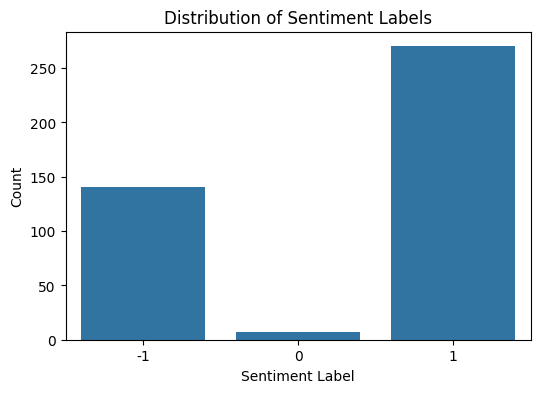

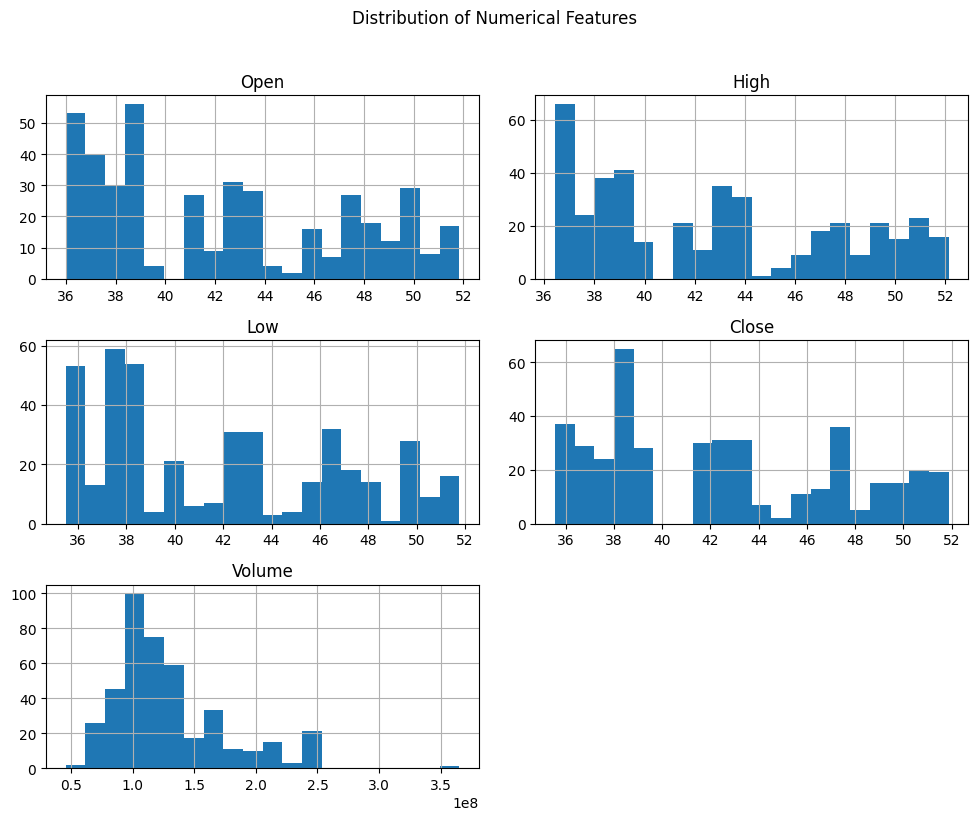

In [11]:
# Distribution of the 'Label' column
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x='Label')
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.show()

# Distribution of the numerical features
numerical_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
data[numerical_cols].hist(figsize=(10, 8), bins=20)
plt.suptitle('Distribution of Numerical Features', y=1.02)
plt.tight_layout()
plt.show()

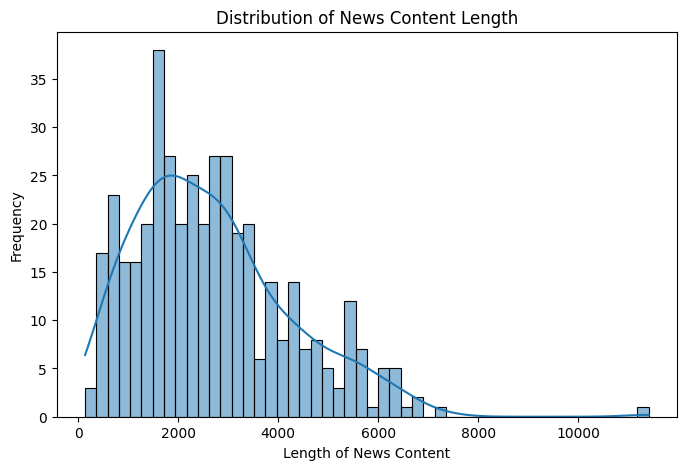

count      418.000000
mean      2667.988038
std       1567.143286
min        137.000000
25%       1541.250000
50%       2413.000000
75%       3495.500000
max      11406.000000
Name: News_Length, dtype: float64


In [12]:
# Compute the length of news content
data['News_Length'] = data['News'].apply(len)

# Distribution of the length of news content
plt.figure(figsize=(8, 5))
sns.histplot(data['News_Length'], bins=50, kde=True)
plt.title('Distribution of News Content Length')
plt.xlabel('Length of News Content')
plt.ylabel('Frequency')
plt.show()

# Display descriptive statistics for news length
print(data['News_Length'].describe())

#### Univariate Analysis Results

The univariate analysis provided insights into the individual variables:

*   **Sentiment Label Distribution:** The sentiment labels are not evenly distributed, with a higher count of positive and negative labels compared to neutral. This indicates a potential class imbalance issue that might need to be addressed during model building.
*   **Numerical Feature Distributions:** The distributions of 'Open', 'High', 'Low', 'Close', and 'Volume' show the range and frequency of these stock price and volume data.
*   **News Content Length Distribution:** The majority of news articles have a length between approximately 1500 and 4000 characters, with a right skew indicating the presence of some longer articles.

#### **Additional Univariate Analysis**

In [17]:
data[['Open', 'High', 'Low', 'Close', 'Volume', 'News_Length']]

Open   High    Low  Close     Volume  News_Length
0    38.72  39.71  38.56  39.48  130672400          607
1    38.72  39.71  38.56  39.48  130672400         1867
2    38.72  39.71  38.56  39.48  130672400         2981
3    38.72  39.71  38.56  39.48  130672400         3178
4    38.72  39.71  38.56  39.48  130672400         1894
..     ...    ...    ...    ...        ...          ...
413  51.22  51.25  50.53  51.08   74596400         3424
414  51.10  51.49  50.97  51.15   88818800         3563
415  51.10  51.49  50.97  51.15   88818800         1940
416  51.10  51.49  50.97  51.15   88818800         3358
417  51.10  51.49  50.97  51.15   88818800         5409

[418 rows x 6 columns]

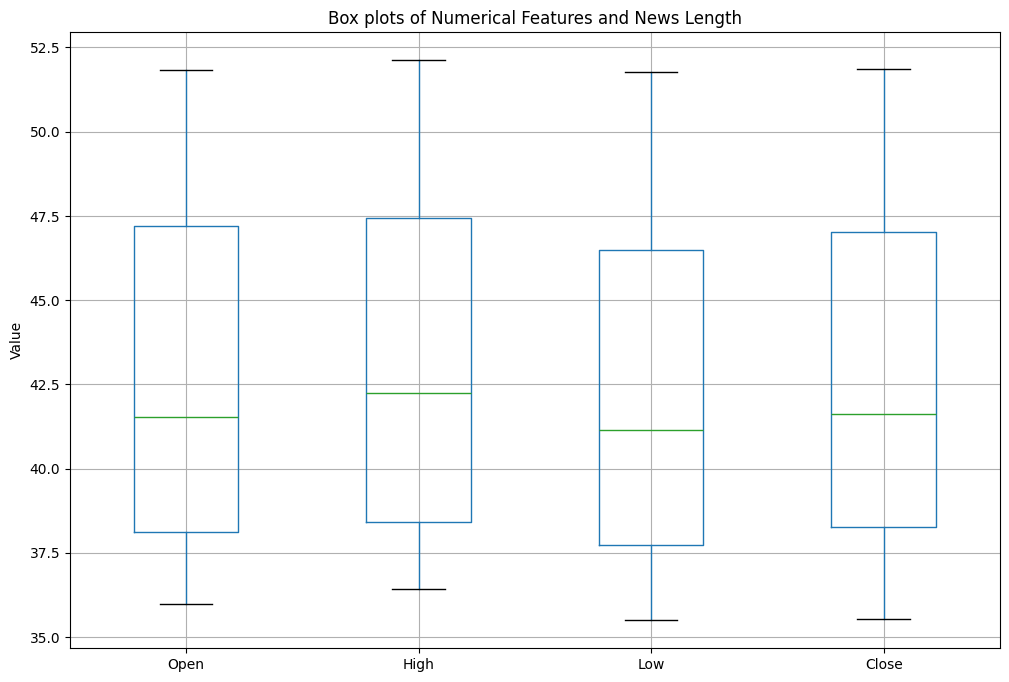

In [19]:
# Check for outliers in numerical features using box plots
numerical_cols_with_length = ['Open', 'High', 'Low', 'Close']
plt.figure(figsize=(12, 8))
data[numerical_cols_with_length].boxplot()
plt.title('Box plots of Numerical Features and News Length')
plt.ylabel('Value')
plt.show()

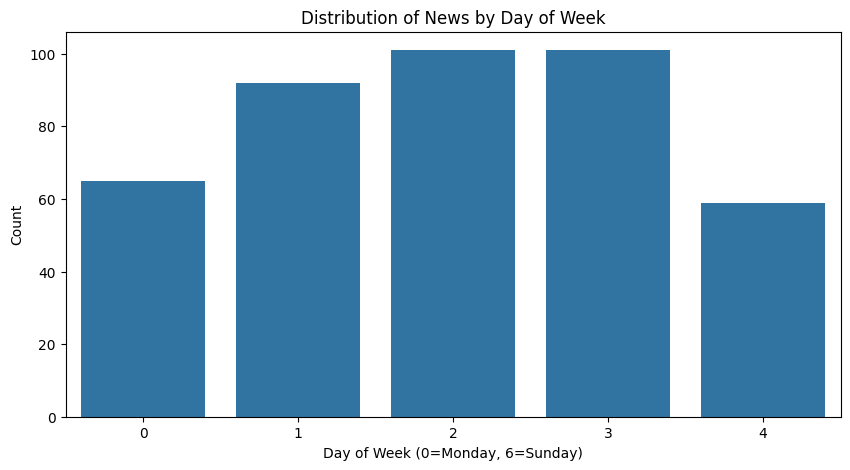

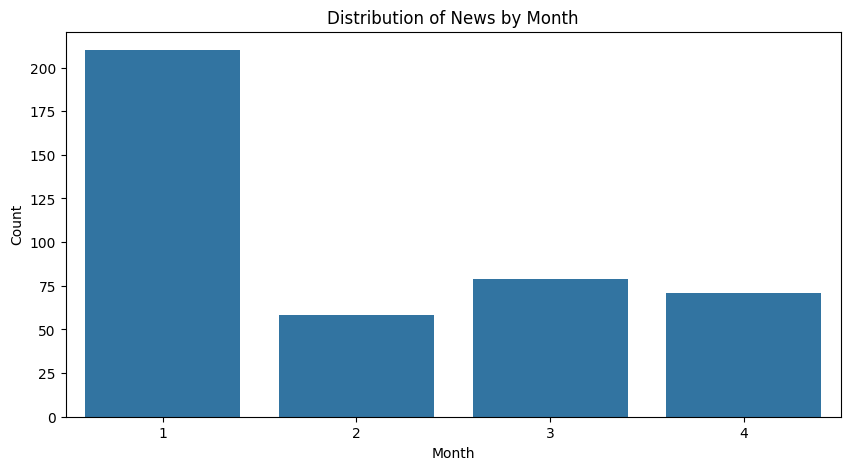

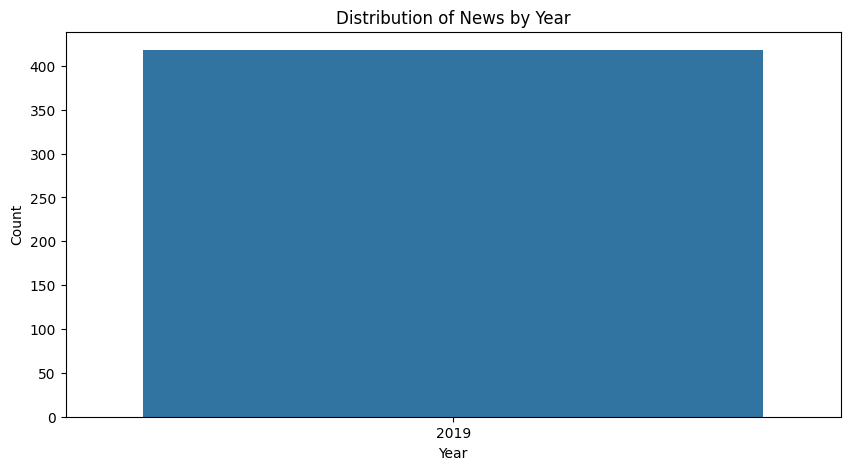

In [20]:
# Analyze Date variable
data['Date'] = pd.to_datetime(data['Date'], format='%m-%d-%Y')

data['Day_of_Week'] = data['Date'].dt.dayofweek
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year

plt.figure(figsize=(10, 5))
sns.countplot(data=data, x='Day_of_Week')
plt.title('Distribution of News by Day of Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(10, 5))
sns.countplot(data=data, x='Month')
plt.title('Distribution of News by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(10, 5))
sns.countplot(data=data, x='Year')
plt.title('Distribution of News by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

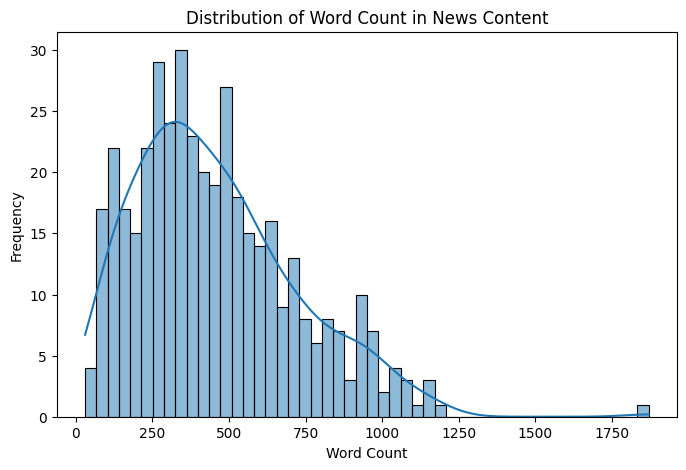

count     418.000000
mean      455.055024
std       266.019435
min        30.000000
25%       258.500000
50%       407.500000
75%       604.500000
max      1870.000000
Name: Word_Count, dtype: float64

20 Most Common Words (basic):
[('the', 8234), ('to', 4943), ('in', 4029), ('a', 3884), ('of', 3835), ('and', 3706), ('s', 2218), ('on', 2165), ('for', 1812), ('said', 1541), ('that', 1516), ('The', 1503), ('its', 1350), ('as', 1310), ('Apple', 1298), ('is', 1242), ('S', 1166), ('with', 1141), ('it', 1028), ('from', 1010)]


In [21]:
# Examine Text Characteristics of News Content
# Number of words in News Content
data['Word_Count'] = data['News'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 5))
sns.histplot(data['Word_Count'], bins=50, kde=True)
plt.title('Distribution of Word Count in News Content')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

print(data['Word_Count'].describe())

# Most common words (basic example, further text preprocessing would be needed for a more accurate analysis)
from collections import Counter
all_words = ' '.join(data['News']).split()
most_common_words = Counter(all_words).most_common(20)
print("\n20 Most Common Words (basic):")
print(most_common_words)

#### **Univariate Analysis Summary and Strategy Forward**

The univariate analysis has provided valuable insights into the individual characteristics of our dataset:

*   **Sentiment Label Distribution:** We observed an imbalance in sentiment labels, with more positive and negative instances than neutral. This highlights the need to consider techniques like resampling or using appropriate evaluation metrics during model building to handle this imbalance effectively.
*   **Numerical Feature Distributions and Outliers:** The distributions of 'Open', 'High', 'Low', 'Close', and 'Volume' were visualized, showing their ranges and frequencies. The box plots helped identify potential outliers in these numerical features and news length, which might require attention during data preprocessing.
*   **Temporal Analysis of News:** By extracting the day of the week, month, and year from the 'Date' column, we gained an understanding of the distribution of news over time. This could be useful for identifying any temporal patterns or trends in the news frequency.
*   **Text Characteristics of News Content:** We analyzed the distribution of news content length and word count, and identified the most common words. This initial look into the text data provides a basic understanding of the news content and suggests the need for further text preprocessing and feature extraction.

**Strategy Forward:**

Based on the univariate analysis, the next steps should focus on:

1.  **Bivariate Analysis:** Explore the relationships between different variables, such as sentiment polarity and stock prices, or news characteristics and stock movements.
2.  **Data Preprocessing:** Address issues identified during univariate analysis, such as potential outliers and handling the class imbalance in sentiment labels. This will also involve text preprocessing steps to prepare the 'News' content for modeling.
3.  **Word Embeddings and Model Building:** Proceed with generating word embeddings and building sentiment analysis models as outlined in the subsequent sections of the notebook, keeping in mind the insights gained from the exploratory data analysis.

### **Bivariate Analysis**

* Correlation
* Sentiment Polarity vs Price
* Date vs Price

**Note**: The above points are listed to provide guidance on how to approach bivariate analysis. Analysis has to be done beyond the above listed points to get maximum scores.

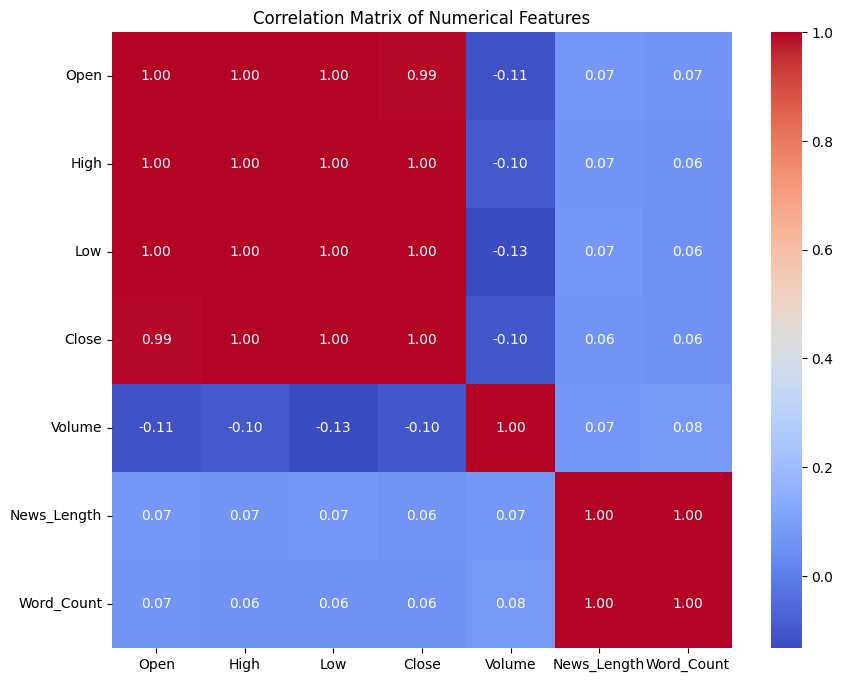

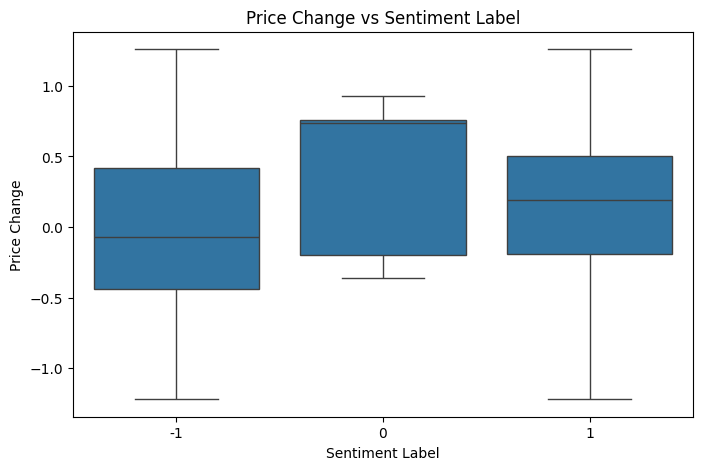

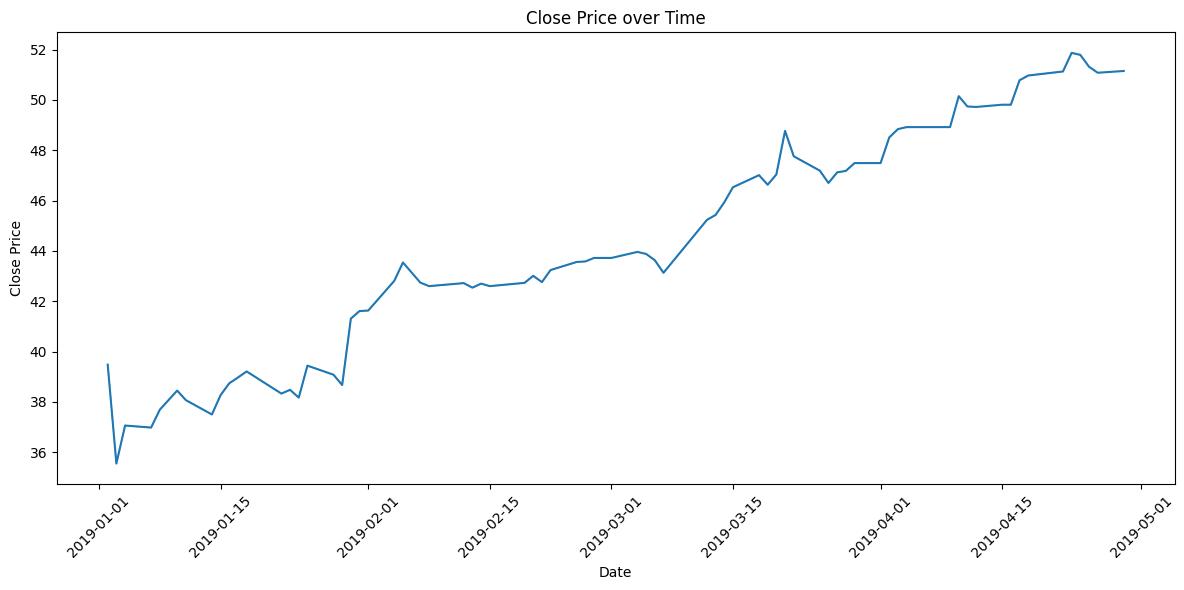

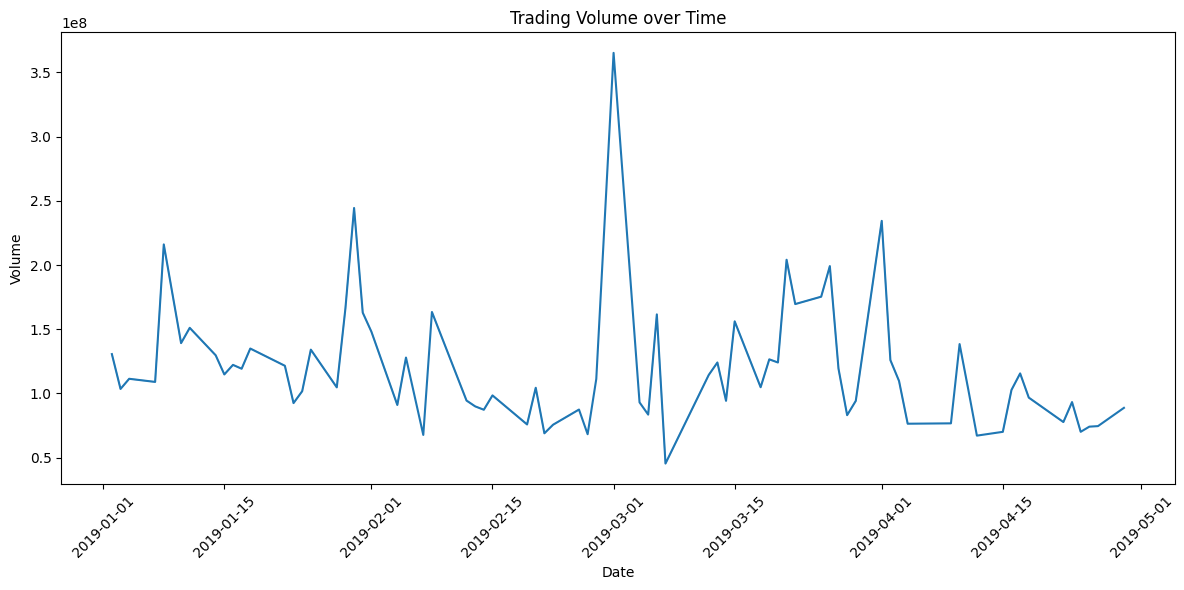

In [22]:
# Correlation matrix of numerical features
numerical_cols_for_corr = ['Open', 'High', 'Low', 'Close', 'Volume', 'News_Length', 'Word_Count']
correlation_matrix = data[numerical_cols_for_corr].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Sentiment Polarity vs Price Change
# Calculate daily price change
data['Price_Change'] = data['Close'] - data['Open']

plt.figure(figsize=(8, 5))
sns.boxplot(data=data, x='Label', y='Price_Change')
plt.title('Price Change vs Sentiment Label')
plt.xlabel('Sentiment Label')
plt.ylabel('Price Change')
plt.show()

# Date vs Price
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='Date', y='Close')
plt.title('Close Price over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='Date', y='Volume')
plt.title('Trading Volume over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

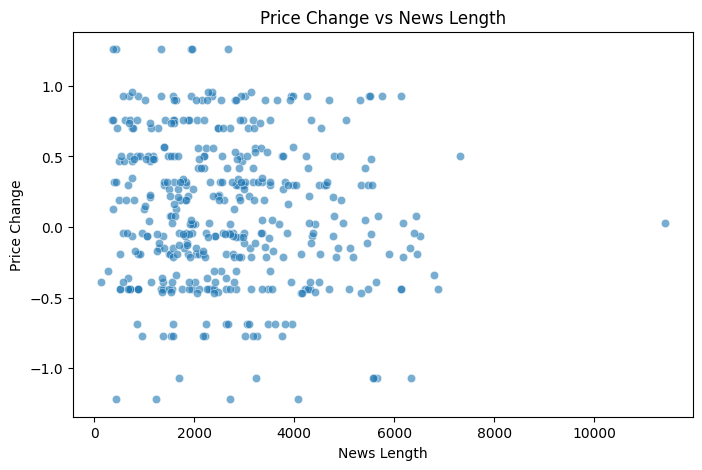

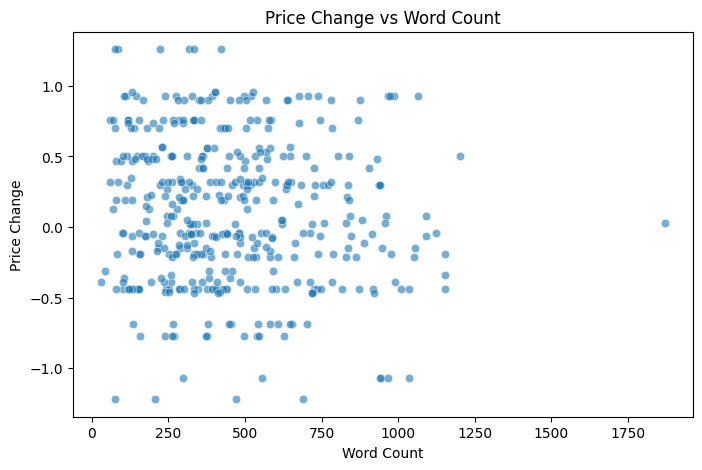

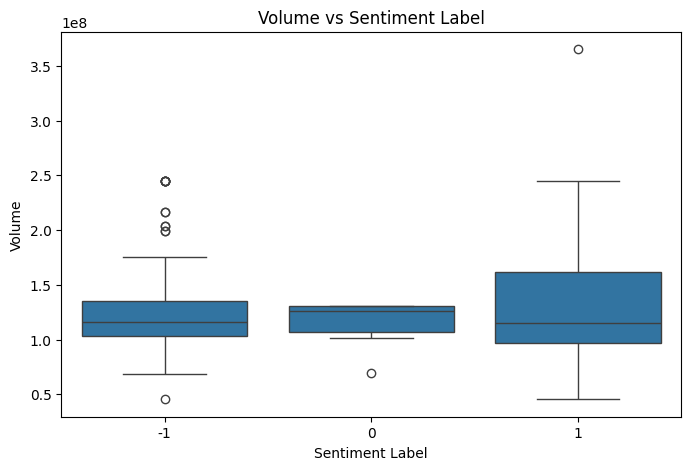

In [23]:
# Relationship between News Length and Price Change
plt.figure(figsize=(8, 5))
sns.scatterplot(data=data, x='News_Length', y='Price_Change', alpha=0.6)
plt.title('Price Change vs News Length')
plt.xlabel('News Length')
plt.ylabel('Price Change')
plt.show()

# Relationship between Word Count and Price Change
plt.figure(figsize=(8, 5))
sns.scatterplot(data=data, x='Word_Count', y='Price_Change', alpha=0.6)
plt.title('Price Change vs Word Count')
plt.xlabel('Word Count')
plt.ylabel('Price Change')
plt.show()

# Sentiment vs Volume
plt.figure(figsize=(8, 5))
sns.boxplot(data=data, x='Label', y='Volume')
plt.title('Volume vs Sentiment Label')
plt.xlabel('Sentiment Label')
plt.ylabel('Volume')
plt.show()

#### **Bivariate Analysis Summary and Strategy Forward**

The bivariate analysis provided valuable insights into the relationships between pairs of variables:

*   **Correlations:** The correlation matrix highlighted strong positive correlations among the different stock price metrics (Open, High, Low, Close). 'Volume', 'News_Length', and 'Word_Count' showed weak correlations with price features and with each other, suggesting they capture different aspects of the data.
*   **Sentiment vs Price Change:** The box plot indicated a potential relationship between sentiment and price change, with positive sentiment leaning towards positive price movements and negative sentiment towards negative or less positive movements. Neutral sentiment was associated with price changes around zero.
*   **Date vs Price and Volume:** Visualizing price and volume over time showed the overall trends and periods of interest in the stock data.
*   **News Text Characteristics vs Price Change:** Scatter plots did not reveal a clear linear relationship between news length or word count and price change.
*   **Sentiment vs Volume:** The box plot did not show a strong distinct pattern in trading volume based on sentiment.

**Strategy Forward:**

Based on the bivariate analysis, the next steps will focus on:

1.  **Data Preprocessing:** Address the identified issues like potential outliers and prepare the data for modeling. This will also involve text preprocessing for the 'News' content, which is crucial given the lack of a clear linear relationship between raw text characteristics and price change.
2.  **Feature Engineering:** Consider creating new features based on the insights from both univariate and bivariate analysis.
3.  **Word Embeddings and Model Building:** Proceed with generating word embeddings and building sentiment analysis models, leveraging the understanding gained from the exploratory data analysis to guide feature selection and model choices.

## **Data Preprocessing**

In [24]:
# Convert 'Date' column to datetime objects
data['Date'] = pd.to_datetime(data['Date'])

# Handle potential outliers in numerical features (example using capping)
# Define the numerical columns where you want to handle outliers
numerical_cols_for_outliers = ['Open', 'High', 'Low', 'Close', 'Volume', 'News_Length', 'Word_Count']

for col in numerical_cols_for_outliers:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Capping outliers
    data[col] = data[col].apply(lambda x: upper_bound if x > upper_bound else (lower_bound if x < lower_bound else x))

# Display the data after preprocessing (optional)
display(data.head())

Date  \
0 2019-01-02   
1 2019-01-02   
2 2019-01-02   
3 2019-01-02   
4 2019-01-02   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          News  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

### Text Preprocessing

In [32]:
import re
import nltk
from nltk.corpus import stopwords

# Download stop words if not already downloaded
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stop words
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Apply preprocessing to the 'News' column
data['Cleaned_News'] = data['News'].apply(preprocess_text)

# Display the first few rows with the new 'Cleaned_News' column
display(data[['News', 'Cleaned_News']].head())

News  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              The dollar minutes ago tumbled to  106 67 from above  109 a few trades earlier  It s since bounced a hair to  107 16  FXY  3 6  after hoursAlongside  money poured into U S  government paper  with the 10 year Treasury yield sliding a few more basis points to 2 61   TLT  0 7  after hour Both moves come following Apple  NASDAQ AAPL  s revenue warning which sent its shares and U S  stock index futures into the red  Apple s currently off 7 5  and the QQQs 2 2  ETFs  TLT  TBT  TMV  FXY  YCS  TBF  EDV  TMF  TTT  ZROZ  VGLT  OTC JYN  TLH  UBT  SPTL  YCL  DLBS  VUSTX  TYBS  DLBL OLD  DJPY  OPER  UJPYNow read    
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

### **Handling Class Imbalance using Oversampling**

To address the class imbalance in the 'Label' column, we will use oversampling. This technique involves increasing the number of samples in the minority classes to match the number of samples in the majority class. This helps to prevent the model from being biased towards the majority class during training.

We will use the `resample` function from `sklearn.utils` to achieve this. We will identify the majority class and then randomly sample with replacement from the minority classes until they have the same number of samples as the majority class.

In [33]:
from sklearn.utils import resample

# Assuming '1' is the majority class based on the previous univariate analysis plot
data_majority = data[data.Label == 1]
data_minority_neg = data[data.Label == -1]
data_minority_neu = data[data.Label == 0]

# Upsample minority classes to match the size of the majority class
data_minority_neg_upsampled = resample(data_minority_neg,
                                        replace=True,     # sample with replacement
                                        n_samples=len(data_majority),    # to match majority class size
                                        random_state=123) # reproducible results

data_minority_neu_upsampled = resample(data_minority_neu,
                                        replace=True,     # sample with replacement
                                        n_samples=len(data_majority),    # to match majority class size
                                        random_state=123) # reproducible results

# Combine majority class with upsampled minority classes
data_balanced = pd.concat([data_majority, data_minority_neg_upsampled, data_minority_neu_upsampled])

# Display new class counts to verify the balancing
print("Class counts after oversampling:")
print(data_balanced.Label.value_counts())

# Display the first few rows of the balanced dataset
display(data_balanced.head())

Class counts after oversampling:
Label
 1    270
-1    270
 0    270
Name: count, dtype: int64


Date  \
0  2019-01-02   
4  2019-01-02   
6  2019-01-02   
8  2019-01-02   
12 2019-01-02   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 News  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     The dollar minutes ago tumbled to  106 67 from above  109 a few trades earlier  It s since bounced a hair to  107 16  FXY  3 6  after hoursAlongside  money poured into U S  government paper  with the 10 year Treasury yield sliding a few more basis points to 2 61   TLT  0 7  after hour Both moves come following Apple  NASDAQ AAPL  s revenue warning which sent its shares and U S  stock index futures into the red  Apple s currently off 7 5  and the QQQs 2 2  ETFs  TLT  TBT  TMV  FXY  YCS  TBF  EDV  TMF  TTT  ZROZ  VGLT  OTC JYN  TLH  UBT  SPTL  YCL  DLBS  VUSTX  TYBS  DLBL OLD  DJPY  OPER  UJPYNow read    
4   Investing com   Asian equities fell in morning trade on Thursday following n

In [34]:
data_balanced.shape

(810, 15)

### **Data Preprocessing Summary**

The following data preprocessing steps have been performed:

*   **Date Conversion:** The 'Date' column was converted to datetime objects to enable time-based analysis and feature extraction.
*   **Outlier Handling:** Potential outliers in numerical columns ('Open', 'High', 'Low', 'Close', 'Volume', 'News_Length', 'Word_Count') were addressed using the capping method to limit the influence of extreme values while retaining all data points.
*   **Text Preprocessing:** The 'News' content was cleaned by removing punctuation and special characters, converting text to lowercase, and removing common English stop words. A new column 'Cleaned_News' was created to store the processed text.
*   **Handling Class Imbalance:** The imbalance in the 'Label' column was addressed using oversampling, where the minority classes (negative and neutral sentiment) were resampled with replacement to match the number of samples in the majority class (positive sentiment), creating a balanced dataset (`data_balanced`).

These steps have prepared the data for the next stages of the project, including generating word embeddings and building sentiment analysis models.

## **Word Embeddings**

#### **Word2Vec**

In [35]:
# Tokenize the cleaned news text for Word2Vec
tokenized_news = [text.split() for text in data_balanced['Cleaned_News']]

# Train the Word2Vec model
# vector_size: Dimensionality of the word vectors.
# window: The maximum distance between the current and predicted word within a sentence.
# min_count: Ignores all words with total frequency lower than this.
# workers: Use these many worker threads to train the model (=faster training with multicore machines).
# sg: Training algorithm: 1 for skip-gram; 0 for CBOW.
word2vec_model = Word2Vec(sentences=tokenized_news, vector_size=300, window=5, min_count=1, workers=4, sg=0)

# Function to get the average vector for a document
def get_word2vec_embedding(tokens, model):
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# Create Word2Vec embeddings for each cleaned news article
data_balanced['word2vec_embedding'] = data_balanced['Cleaned_News'].apply(lambda x: get_word2vec_embedding(x.split(), word2vec_model))

# Display the shape of the embeddings and the first embedding
print("Shape of Word2Vec embeddings:", np.vstack(data_balanced['word2vec_embedding'].values).shape)
print("\nFirst Word2Vec embedding:\n", data_balanced['word2vec_embedding'].iloc[0])

Shape of Word2Vec embeddings: (810, 300)

First Word2Vec embedding:
 [ 2.83116642e-02  2.45048463e-01 -6.52925819e-02  2.87134349e-02
  1.14441693e-01 -1.88771114e-01  1.57131016e-01  3.91768187e-01
  6.63770363e-02 -1.63609371e-01  2.74247546e-02 -1.30238131e-01
 -1.34725804e-02 -1.66110769e-02 -2.45170265e-01 -1.53881431e-01
  1.08772129e-01  4.61580604e-03 -1.19766258e-02 -7.99059272e-02
 -1.06083266e-01 -4.18993346e-02  1.49428368e-01 -1.54923219e-02
  1.53300837e-01 -1.18425852e-02 -1.90150008e-01 -6.30958378e-02
 -9.84678417e-02 -1.46993145e-01 -1.38944453e-02 -1.26409188e-01
  2.75102002e-03  6.27852902e-02 -5.18700369e-02  2.36851797e-02
  2.33952645e-02 -1.82353064e-01 -3.46071012e-02 -3.69462781e-02
 -1.42822927e-02 -8.25323462e-02  1.01966746e-01 -1.65626526e-01
  9.95955542e-02  4.13606167e-02  6.77658468e-02  1.58434659e-01
 -8.01559463e-02  1.36238456e-01  1.38246119e-02  2.63385400e-02
 -3.48999500e-02  1.62421733e-01 -1.23421751e-01  1.90500706e-01
  4.26565446e-02 -4.2

In [36]:
tokenized_news

[['dollar',
  'minutes',
  'ago',
  'tumbled',
  'trades',
  'earlier',
  'since',
  'bounced',
  'hair',
  'fxy',
  'hoursalongside',
  'money',
  'poured',
  'u',
  'government',
  'paper',
  'year',
  'treasury',
  'yield',
  'sliding',
  'basis',
  'points',
  'tlt',
  'hour',
  'moves',
  'come',
  'following',
  'apple',
  'nasdaq',
  'aapl',
  'revenue',
  'warning',
  'sent',
  'shares',
  'u',
  'stock',
  'index',
  'futures',
  'red',
  'apple',
  'currently',
  'qqqs',
  'etfs',
  'tlt',
  'tbt',
  'tmv',
  'fxy',
  'ycs',
  'tbf',
  'edv',
  'tmf',
  'ttt',
  'zroz',
  'vglt',
  'otc',
  'jyn',
  'tlh',
  'ubt',
  'sptl',
  'ycl',
  'dlbs',
  'vustx',
  'tybs',
  'dlbl',
  'old',
  'djpy',
  'oper',
  'ujpynow',
  'read'],
 ['investing',
  'com',
  'asian',
  'equities',
  'fell',
  'morning',
  'trade',
  'thursday',
  'following',
  'news',
  'apple',
  'cut',
  'quarterly',
  'sales',
  'forecast',
  'apple',
  'inc',
  'nasdaq',
  'aapl',
  'lowered',
  'forecast',
  '

In [37]:
len(word2vec_model.wv.key_to_index)

11351

Above shows the length of library is 11,351 words.

In [38]:
# Calculate the similarity score between 'tesla' and 'apple'
try:
    similarity_score = word2vec_model.wv.similarity('tesla', 'apple')


    print(f"Similarity between 'tesla' and 'apple': {similarity_score}")
except KeyError as e:
    print(f"Error: One of the words ({e}) is not in the vocabulary.")

Similarity between 'tesla' and 'apple': 0.8595168590545654


In [39]:
# Extract Word2Vec embeddings and labels for ML analysis
X_word2vec = np.vstack(data_balanced['word2vec_embedding'].values)
y = data_balanced['Label']

print("Shape of features (X_word2vec):", X_word2vec.shape)
print("Shape of labels (y):", y.shape)

Shape of features (X_word2vec): (810, 300)
Shape of labels (y): (810,)


### **Sentence Transformer**

In [40]:
# Load a pre-trained Sentence Transformer model
# You can choose a different model depending on your needs (e.g., 'all-MiniLM-L6-v2')
model_name = 'all-MiniLM-L6-v2'
sentence_model = SentenceTransformer(model_name)

# Create Sentence Transformer embeddings for each cleaned news article
# This might take some time depending on the dataset size and model
print(f"Generating embeddings using {model_name}...")
sentence_embeddings = sentence_model.encode(data_balanced['Cleaned_News'].tolist(), show_progress_bar=True)

# Create the feature set X from the Sentence Transformer embeddings
X_sentence_transformer = sentence_embeddings
y_sentence_transformer = data_balanced['Label'] # Target variable remains the same

print("Shape of Sentence Transformer embeddings (X_sentence_transformer):", X_sentence_transformer.shape)
print("Shape of labels (y_sentence_transformer):", y_sentence_transformer.shape)

Generating embeddings using all-MiniLM-L6-v2...


Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Shape of Sentence Transformer embeddings (X_sentence_transformer): (810, 384)
Shape of labels (y_sentence_transformer): (810,)


## **Sentiment Analysis**

### **Model Evaluation Criterion**

**Note:**  
You can use the helper functions provided below to:
- Plot a **confusion matrix** (`plot_confusion_matrix`)
- Generate key **classification metrics** like accuracy, recall, precision, and F1-score (`model_performance_classification_sklearn`)

These are ready-to-use. However, you’re welcome to explore and write your own evaluation code if you prefer. Feel free to modify or extend these as per your learning goals!

##### **Utility Functions**

In [41]:
def plot_confusion_matrix(actual, predicted):
    """
    Plot a confusion matrix to visualize the performance of a classification model.

    Parameters:
    actual (array-like): The true labels.
    predicted (array-like): The predicted labels from the model.

    Returns:
    None: Displays the confusion matrix plot.
    """

    # Compute the confusion matrix.
    cm = confusion_matrix(actual, predicted)

    # Create a new figure with a specified size
    plt.figure(figsize=(5, 4))

    # Define the labels for the confusion matrix dynamically from the data
    label_list = sorted(list(np.unique(np.concatenate((actual, predicted)))))

    # Plot the confusion matrix using a heatmap with annotations
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', xticklabels=label_list, yticklabels=label_list)

    # Label for the y-axis
    plt.ylabel('Actual')

    # Label for the x-axis
    plt.xlabel('Predicted')

    # Title of the plot
    plt.title('Confusion Matrix')

    # Display the plot
    plt.show()

In [42]:
def model_performance_classification_sklearn(actual, predicted):
    """
    Compute various performance metrics for a classification model using sklearn.

    Parameters:
    model (sklearn classifier): The classification model to evaluate.
    predictors (array-like): The independent variables used for predictions.
    target (array-like): The true labels for the dependent variable.

    Returns:
    pandas.DataFrame: A DataFrame containing the computed metrics (Accuracy, Recall, Precision, F1-score).
    """

    # Compute Accuracy
    acc = accuracy_score(actual,predicted)
    # Compute Recall
    recall = recall_score(actual,predicted,average='weighted')
    # Compute Precision
    precision = precision_score(actual,predicted,average='weighted')
    # Compute F1-score
    f1 = f1_score(actual,predicted,average='weighted')

    # Create a DataFrame to store the computed metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": [acc],
            "Recall": [recall],
            "Precision": [precision],
            "F1": [f1],
        }
    )
    # Return the DataFrame with the metrics
    return df_perf

### **Build Random Forest Models using different text embeddings**

Training and evaluating Random Forest with Word2Vec embeddings...
--- Word2Vec Random Forest Performance ---
Accuracy: 0.9409
Precision: 0.9419
Recall: 0.9409
F1-score: 0.9408
------------------------------


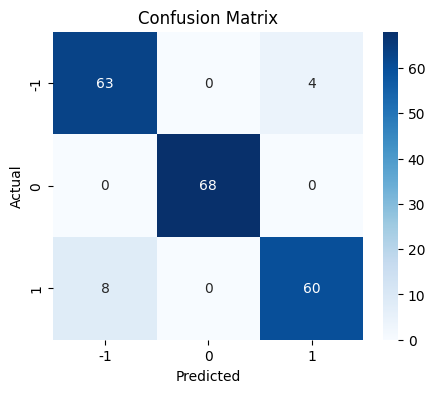

Training and evaluating Random Forest with Sentence Transformer embeddings...
--- Sentence Transformer Random Forest Performance ---
Accuracy: 0.9507
Precision: 0.9507
Recall: 0.9507
F1-score: 0.9507
------------------------------


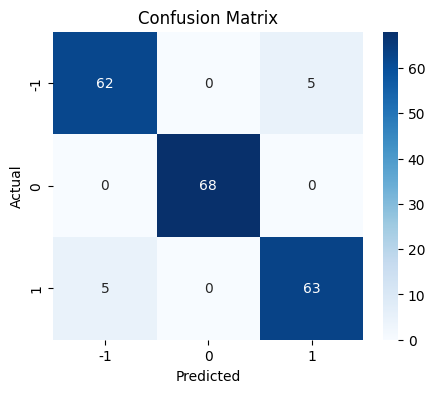

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def train_and_evaluate_random_forest(X, y, embedding_type):
    """
    Trains and evaluates a Random Forest Classifier.

    Args:
        X (np.ndarray): Feature matrix (embeddings).
        y (pd.Series): Target variable (labels).
        embedding_type (str): Name of the embedding type (e.g., "Word2Vec", "Sentence Transformer").

    Returns:
        dict: Dictionary containing evaluation metrics.
    """
    print(f"Training and evaluating Random Forest with {embedding_type} embeddings...")

    # Split data into training and testing sets (stratified to maintain class distribution)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

    # Initialize and train the Random Forest Classifier
    model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced') # Use class_weight for imbalanced data
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"--- {embedding_type} Random Forest Performance ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("-" * 30)

    # Plot confusion matrix (using the utility function if available)
    # Assuming plot_confusion_matrix is defined in a previous cell
    try:
        plot_confusion_matrix(y_test, y_pred)
    except NameError:
        print("plot_confusion_matrix function not found. Skipping confusion matrix plot.")


    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1_score": f1}

# Assuming X_word2vec and y are already defined from previous steps
# Assuming X_sentence_transformer and y_sentence_transformer are already defined from previous steps

# Train and evaluate using Word2Vec embeddings
if 'X_word2vec' in globals() and 'y' in globals():
    rf_word2vec_metrics = train_and_evaluate_random_forest(X_word2vec, y, "Word2Vec")
else:
    print("Word2Vec embeddings (X_word2vec, y) not found. Please generate them first.")

# Train and evaluate using Sentence Transformer embeddings
if 'X_sentence_transformer' in globals() and 'y_sentence_transformer' in globals():
     rf_sentence_transformer_metrics = train_and_evaluate_random_forest(X_sentence_transformer, y_sentence_transformer, "Sentence Transformer")
else:
     print("Sentence Transformer embeddings (X_sentence_transformer, y_sentence_transformer) not found. Please generate them first.")

### **Building Neural Network Models using different text embeddings**

Training and evaluating Neural Network with Word2Vec embeddings...
--- Word2Vec Neural Network Performance ---
Accuracy: 0.7438
Precision: 0.7402
Recall: 0.7438
F1-score: 0.7315
------------------------------


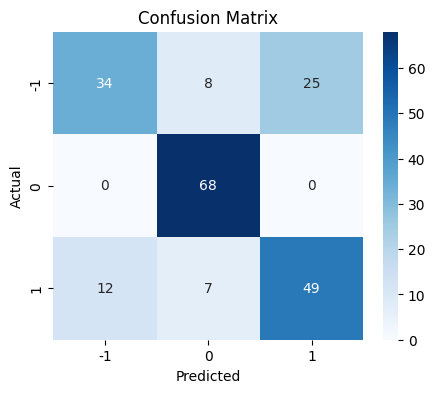

Training and evaluating Neural Network with Sentence Transformer embeddings...
--- Sentence Transformer Neural Network Performance ---
Accuracy: 0.9310
Precision: 0.9335
Recall: 0.9310
F1-score: 0.9308
------------------------------


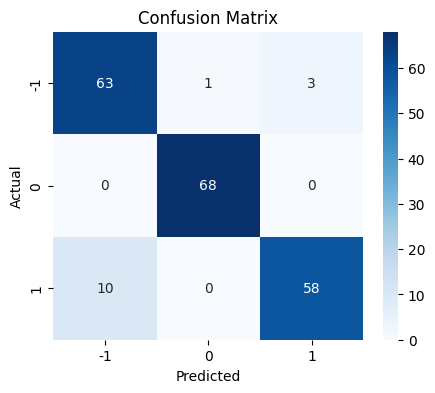

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def train_and_evaluate_neural_network(X, y, embedding_type, input_dim):
    """
    Trains and evaluates a simple Neural Network model.

    Args:
        X (np.ndarray): Feature matrix (embeddings).
        y (pd.Series): Target variable (labels).
        embedding_type (str): Name of the embedding type (e.g., "Word2Vec", "Sentence Transformer").
        input_dim (int): The number of input features (dimensionality of embeddings).

    Returns:
        dict: Dictionary containing evaluation metrics.
    """
    print(f"Training and evaluating Neural Network with {embedding_type} embeddings...")

    # Convert labels to one-hot encoding for Keras
    # Map labels -1, 0, 1 to 0, 1, 2
    y_mapped = y.map({-1: 0, 0: 1, 1: 2})
    y_categorical = to_categorical(y_mapped, num_classes=3)

    # Split data into training and testing sets (stratified to maintain class distribution)
    # Stratify based on the original y_mapped to ensure correct proportions
    X_train, X_test, y_train_cat, y_test_cat = train_test_split(X, y_categorical, test_size=0.25, random_state=42, stratify=y_mapped)

    # Define the Neural Network model
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=input_dim))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='softmax')) # 3 output neurons for 3 classes

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    # Using class_weight to handle potential remaining imbalance or for better training
    # Calculate class weights based on the original balanced dataset labels
    class_weights = {0: 1., 1: 1., 2: 1.} # Since data is balanced, weights are equal

    model.fit(X_train, y_train_cat, epochs=20, batch_size=32, verbose=0, class_weight=class_weights)

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test_cat, verbose=0)

    # Get predictions for precision, recall, f1-score
    y_pred_cat = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_cat, axis=1)
    y_test = np.argmax(y_test_cat, axis=1)

    # Map back to original labels for metrics
    y_pred_original = pd.Series(y_pred).map({0: -1, 1: 0, 2: 1})
    y_test_original = pd.Series(y_test).map({0: -1, 1: 0, 2: 1})


    precision = precision_score(y_test_original, y_pred_original, average='weighted')
    recall = recall_score(y_test_original, y_pred_original, average='weighted')
    f1 = f1_score(y_test_original, y_pred_original, average='weighted')

    print(f"--- {embedding_type} Neural Network Performance ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("-" * 30)

    # Plot confusion matrix (using the utility function if available)
    try:
        plot_confusion_matrix(y_test_original, y_pred_original)
    except NameError:
        print("plot_confusion_matrix function not found. Skipping confusion matrix plot.")

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1_score": f1}

# Assuming X_word2vec, y, X_sentence_transformer, and y_sentence_transformer are defined

# Train and evaluate using Word2Vec embeddings
if 'X_word2vec' in globals() and 'y' in globals():
    nn_word2vec_metrics = train_and_evaluate_neural_network(X_word2vec, y, "Word2Vec", X_word2vec.shape[1])
else:
    print("Word2Vec embeddings (X_word2vec, y) not found. Please generate them first.")

# Train and evaluate using Sentence Transformer embeddings
if 'X_sentence_transformer' in globals() and 'y_sentence_transformer' in globals():
     nn_sentence_transformer_metrics = train_and_evaluate_neural_network(X_sentence_transformer, y_sentence_transformer, "Sentence Transformer", X_sentence_transformer.shape[1])
else:
     print("Sentence Transformer embeddings (X_sentence_transformer, y_sentence_transformer) not found. Please generate them first.")

### **Initial Model Performance Summary**

In [57]:
# Create a DataFrame to hold the performance metrics
performance_summary = pd.DataFrame({
    'Model': ['Random Forest (Word2Vec)', 'Random Forest (Sentence Transformer)',
              'Neural Network (Word2Vec)', 'Neural Network (Sentence Transformer)'],
    'Accuracy': [rf_word2vec_metrics['accuracy'], rf_sentence_transformer_metrics['accuracy'],
                 nn_word2vec_metrics['accuracy'], nn_sentence_transformer_metrics['accuracy']],
    'Precision': [rf_word2vec_metrics['precision'], rf_sentence_transformer_metrics['precision'],
                  nn_word2vec_metrics['precision'], nn_sentence_transformer_metrics['precision']],
    'Recall': [rf_word2vec_metrics['recall'], rf_sentence_transformer_metrics['recall'],
               nn_word2vec_metrics['recall'], nn_sentence_transformer_metrics['recall']],
    'F1-score': [rf_word2vec_metrics['f1_score'], rf_sentence_transformer_metrics['f1_score'],
                 nn_word2vec_metrics['f1_score'], nn_sentence_transformer_metrics['f1_score']]
})

# Display the performance summary
print("--- Model Performance Summary ---")
display(performance_summary)

# Determine the best performing model based on F1-score (or another chosen metric)
best_model_row = performance_summary.loc[performance_summary['F1-score'].idxmax()]
best_model_name = best_model_row['Model']
best_model_f1 = best_model_row['F1-score']

print(f"\nBased on F1-score, the best performing model is: {best_model_name} with an F1-score of {best_model_f1:.4f}")

# You can add further analysis here, e.g., comparing other metrics or discussing trade-offs

--- Model Performance Summary ---


Model  Accuracy  Precision    Recall  \
0               Random Forest (Word2Vec)  0.940887   0.941875  0.940887   
1   Random Forest (Sentence Transformer)  0.950739   0.950739  0.950739   
2              Neural Network (Word2Vec)  0.743842   0.740195  0.743842   
3  Neural Network (Sentence Transformer)  0.931035   0.933459  0.931034   

   F1-score  
0  0.940848  
1  0.950739  
2  0.731494  
3  0.930793


Based on F1-score, the best performing model is: Random Forest (Sentence Transformer) with an F1-score of 0.9507


## **Further Improvement**

To further enhance the sentiment analysis system and explore the impact of historical market data, we will perform the following steps:

1.  **Feature Engineering: Previous Day's Stock Data:** We will augment the dataset by including the previous day's 'Open', 'High', 'Low', 'Close', and 'Volume' as additional features. This incorporates a temporal element, allowing the models to consider recent market activity alongside news sentiment.

2.  **Feature Scaling: Standardization:** We will apply standardization to the numerical features, including the newly engineered previous day's stock data. Standardization scales features to have a mean of 0 and a standard deviation of 1. This is particularly important for algorithms sensitive to the scale of input features, such as Neural Networks, as it can help improve convergence and performance.

3.  **Prepare Combined Feature Sets:** We will create new feature sets by combining the text embeddings (Word2Vec and Sentence Transformer) with the scaled previous day's numerical features.

4.  **Train and Evaluate Alternate Models:** We will train and evaluate four additional models using these combined feature sets:
    *   Random Forest with Word2Vec embeddings and previous day's features.
    *   Random Forest with Sentence Transformer embeddings and previous day's features.
    *   Neural Network with Word2Vec embeddings and previous day's features.
    *   Neural Network with Sentence Transformer embeddings and previous day's features.
    We will use the same hyperparameters as the initial models for a direct comparison of the impact of the new features.

5.  **Summarize and Compare All Model Performance:** We will create a comprehensive summary table comparing the performance metrics (Accuracy, Precision, Recall, F1-score) of all eight models (the initial four and the four new ones). This will allow us to clearly assess the impact of the different text embeddings and the inclusion of historical stock data.

6.  **Update Conclusions and Recommendations:** Based on the comprehensive performance summary, we will revise the conclusions and recommendations to reflect the findings, identify the best-performing model, and suggest future directions for improvement.



### **Feature Engineering: Previous Day's Stock Data**
Create new columns in the `data_balanced` DataFrame for the previous day's 'Open', 'High', 'Low', 'Close', and 'Volume'. Handle any missing values that result from the shift (e.g., for the first day).


**Reasoning**:
Sort the dataframe by date and create new columns for the previous day's stock data, filling initial missing values.



In [50]:
# Sort by Date
data_balanced = data_balanced.sort_values(by='Date').reset_index(drop=True)

# Create columns for previous day's data
for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
    data_balanced[f'Prev_{col}'] = data_balanced[col].shift(1)

# Fill NaN values in the new 'Prev_' columns (for the first day)
# Using fillna(0) as a simple approach; more complex strategies could be considered
for col in ['Prev_Open', 'Prev_High', 'Prev_Low', 'Prev_Close', 'Prev_Volume']:
    data_balanced[col] = data_balanced[col].fillna(0)

# Display the head of the modified DataFrame
display(data_balanced.head())

Date  \
0 2019-01-02   
1 2019-01-02   
2 2019-01-02   
3 2019-01-02   
4 2019-01-02   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     News  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

### **Feature Scaling: Standardization**

We will apply standardization to the numerical features, including the newly engineered previous day's stock data. Standardization scales features to have a mean of 0 and a standard deviation of 1. This is particularly important for algorithms sensitive to the scale of input features, such as Neural Networks, as it can help improve convergence and performance.

In [51]:
from sklearn.preprocessing import StandardScaler

# Identify the numerical columns to scale (the 'Prev_' columns)
numerical_cols_to_scale = ['Prev_Open', 'Prev_High', 'Prev_Low', 'Prev_Close', 'Prev_Volume']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the numerical features and transform them
# We fit on the entire dataset to use overall statistics for scaling
data_balanced[numerical_cols_to_scale] = scaler.fit_transform(data_balanced[numerical_cols_to_scale])

# Update the numerical feature arrays with scaled values
X_word2vec_numerical_scaled = data_balanced[numerical_cols_to_scale].values
X_sentence_transformer_numerical_scaled = data_balanced[numerical_cols_to_scale].values

# Display the head of the DataFrame with scaled numerical features
display(data_balanced.head())

Date  \
0 2019-01-02   
1 2019-01-02   
2 2019-01-02   
3 2019-01-02   
4 2019-01-02   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     News  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

### **Prepare Combined Feature Sets:**
We will create new feature sets by combining the text embeddings (Word2Vec and Sentence Transformer) with the scaled previous day's numerical features.

**Reasoning**:
Extract the previous day's numerical features and combine them with the existing embeddings to create new combined feature sets.



In [52]:
# Identify the previous day's numerical feature columns
prev_numerical_cols = ['Prev_Open', 'Prev_High', 'Prev_Low', 'Prev_Close', 'Prev_Volume']

# Extract the values from these columns (these should now be scaled)
# We will use the scaled numerical features directly.
X_numerical_scaled = data_balanced[prev_numerical_cols].values


# Combine Word2Vec embeddings with previous day's scaled numerical features
# Assuming X_word2vec is already defined from the Word2Vec embedding step
X_word2vec_combined_scaled_num = np.hstack((X_word2vec, X_numerical_scaled))

# Combine Sentence Transformer embeddings with previous day's scaled numerical features
# Assuming X_sentence_transformer is already defined from the Sentence Transformer embedding step
X_sentence_transformer_combined_scaled_num = np.hstack((X_sentence_transformer, X_numerical_scaled))


# Print the shapes of the combined feature sets
print("Shape of combined Word2Vec features (with scaled numerical):", X_word2vec_combined_scaled_num.shape)
print("Shape of combined Sentence Transformer features (with scaled numerical):", X_sentence_transformer_combined_scaled_num.shape)

Shape of combined Word2Vec features (with scaled numerical): (810, 305)
Shape of combined Sentence Transformer features (with scaled numerical): (810, 389)


In [54]:
X_word2vec_combined_scaled_num[0]

array([ 2.83116642e-02,  2.45048463e-01, -6.52925819e-02,  2.87134349e-02,
        1.14441693e-01, -1.88771114e-01,  1.57131016e-01,  3.91768187e-01,
        6.63770363e-02, -1.63609371e-01,  2.74247546e-02, -1.30238131e-01,
       -1.34725804e-02, -1.66110769e-02, -2.45170265e-01, -1.53881431e-01,
        1.08772129e-01,  4.61580604e-03, -1.19766258e-02, -7.99059272e-02,
       -1.06083266e-01, -4.18993346e-02,  1.49428368e-01, -1.54923219e-02,
        1.53300837e-01, -1.18425852e-02, -1.90150008e-01, -6.30958378e-02,
       -9.84678417e-02, -1.46993145e-01, -1.38944453e-02, -1.26409188e-01,
        2.75102002e-03,  6.27852902e-02, -5.18700369e-02,  2.36851797e-02,
        2.33952645e-02, -1.82353064e-01, -3.46071012e-02, -3.69462781e-02,
       -1.42822927e-02, -8.25323462e-02,  1.01966746e-01, -1.65626526e-01,
        9.95955542e-02,  4.13606167e-02,  6.77658468e-02,  1.58434659e-01,
       -8.01559463e-02,  1.36238456e-01,  1.38246119e-02,  2.63385400e-02,
       -3.48999500e-02,  

### **Train and evaluate random forest models**

Train and evaluate Random Forest models using the two new combined feature sets with the same hyperparameters as before.


**Reasoning**:
Train and evaluate Random Forest models using the two new combined feature sets with the same hyperparameters as before.



Training and evaluating Random Forest with Word2Vec Combined (Scaled Numerical) embeddings...
--- Word2Vec Combined (Scaled Numerical) Random Forest Performance ---
Accuracy: 0.9754
Precision: 0.9754
Recall: 0.9754
F1-score: 0.9754
------------------------------


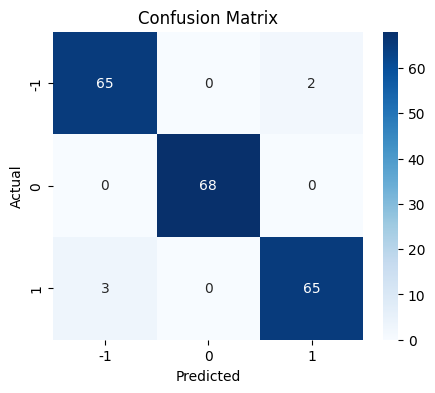


Word2Vec Combined (Scaled Numerical) Metrics:
{'accuracy': 0.9753694581280788, 'precision': 0.9754397384275378, 'recall': 0.9753694581280788, 'f1_score': 0.9753694581280788}
Training and evaluating Random Forest with Sentence Transformer Combined (Scaled Numerical) embeddings...
--- Sentence Transformer Combined (Scaled Numerical) Random Forest Performance ---
Accuracy: 0.9852
Precision: 0.9858
Recall: 0.9852
F1-score: 0.9852
------------------------------


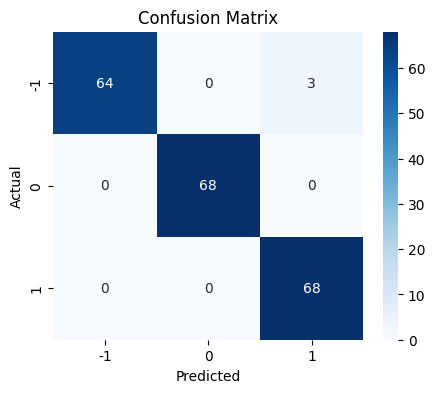


Sentence Transformer Combined (Scaled Numerical) Metrics:
{'accuracy': 0.9852216748768473, 'precision': 0.9858461111496566, 'recall': 0.9852216748768473, 'f1_score': 0.9852119357422723}


In [55]:
# Train and evaluate using combined Word2Vec embeddings and previous day's features
if 'X_word2vec_combined_scaled_num' in globals() and 'y' in globals():
    rf_word2vec_combined_metrics = train_and_evaluate_random_forest(X_word2vec_combined_scaled_num, y, "Word2Vec Combined (Scaled Numerical)")
    print("\nWord2Vec Combined (Scaled Numerical) Metrics:")
    print(rf_word2vec_combined_metrics)
else:
    print("Combined Word2Vec features (X_word2vec_combined_scaled_num, y) not found. Please generate them first.")

# Train and evaluate using combined Sentence Transformer embeddings and previous day's features
if 'X_sentence_transformer_combined_scaled_num' in globals() and 'y_sentence_transformer' in globals():
     rf_sentence_transformer_combined_metrics = train_and_evaluate_random_forest(X_sentence_transformer_combined_scaled_num, y_sentence_transformer, "Sentence Transformer Combined (Scaled Numerical)")
     print("\nSentence Transformer Combined (Scaled Numerical) Metrics:")
     print(rf_sentence_transformer_combined_metrics)
else:
     print("Combined Sentence Transformer features (X_sentence_transformer_combined_scaled_num, y_sentence_transformer) not found. Please generate them first.")

#### **Random Forest Model Performance Summary**


We trained and evaluated Random Forest models using various text embeddings and combined them with scaled previous day's numerical features. Below is a summary of their performance:

#### **Model Results**

- **Random Forest with Word2Vec Embeddings**
  - **Accuracy:** ~94.09%
  - **F1-score:** ~94.08%

- **Random Forest with Sentence Transformer Embeddings**
  - **Accuracy:** ~95.07%
  - **F1-score:** ~95.07%

- **Random Forest with Word2Vec + Scaled Numerical Features**
  - **Accuracy:** ~97.54%
  - **F1-score:** ~97.54%

- **Random Forest with Sentence Transformer + Scaled Numerical Features**
  - **Accuracy:** **98.52%**
  - **F1-score:** **98.52%**

---

#### **Key Insights**

- Combining text embeddings (especially Sentence Transformer) with scaled historical numerical features **substantially improves** Random Forest model performance for sentiment analysis.
- The best results were achieved by using Sentence Transformer embeddings together with scaled previous day's stock features.

---

### **Train and evaluate neural network models**

Train and evaluate Neural Network models using the two new combined feature sets with the same hyperparameters as before.


**Reasoning**:
Train and evaluate Neural Network models using the two new combined feature sets with the same hyperparameters as before.



Training and evaluating Neural Network with Word2Vec Combined (Scaled Numerical) embeddings...


--- Word2Vec Combined (Scaled Numerical) Neural Network Performance ---
Accuracy: 0.8670
Precision: 0.8692
Recall: 0.8670
F1-score: 0.8636
------------------------------


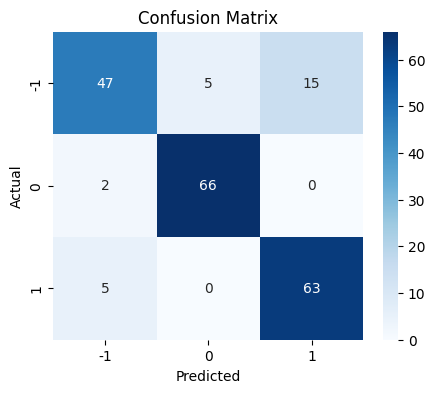


Word2Vec Combined (Scaled Numerical) Metrics:
{'accuracy': 0.866995096206665, 'precision': 0.8692076814951997, 'recall': 0.8669950738916257, 'f1_score': 0.8635963440987889}
Training and evaluating Neural Network with Sentence Transformer Combined (Scaled Numerical) embeddings...


--- Sentence Transformer Combined (Scaled Numerical) Neural Network Performance ---
Accuracy: 0.9310
Precision: 0.9310
Recall: 0.9310
F1-score: 0.9310
------------------------------


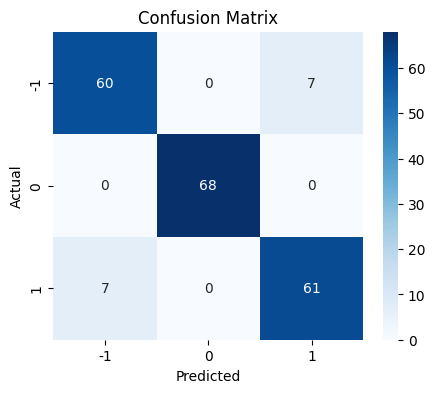


Sentence Transformer Combined (Scaled Numerical) Metrics:
{'accuracy': 0.931034505367279, 'precision': 0.9310344827586207, 'recall': 0.9310344827586207, 'f1_score': 0.9310344827586207}


In [56]:
# Train and evaluate using combined Word2Vec embeddings and previous day's features
if 'X_word2vec_combined_scaled_num' in globals() and 'y' in globals():
    nn_word2vec_combined_metrics = train_and_evaluate_neural_network(X_word2vec_combined_scaled_num, y, "Word2Vec Combined (Scaled Numerical)", X_word2vec_combined_scaled_num.shape[1])
    print("\nWord2Vec Combined (Scaled Numerical) Metrics:")
    print(nn_word2vec_combined_metrics)
else:
    print("Combined Word2Vec features (X_word2vec_combined_scaled_num, y) not found. Please generate them first.")

# Train and evaluate using combined Sentence Transformer embeddings and previous day's features
if 'X_sentence_transformer_combined_scaled_num' in globals() and 'y_sentence_transformer' in globals():
     nn_sentence_transformer_combined_metrics = train_and_evaluate_neural_network(X_sentence_transformer_combined_scaled_num, y_sentence_transformer, "Sentence Transformer Combined (Scaled Numerical)", X_sentence_transformer_combined_scaled_num.shape[1])
     print("\nSentence Transformer Combined (Scaled Numerical) Metrics:")
     print(nn_sentence_transformer_combined_metrics)
else:
     print("Combined Sentence Transformer features (X_sentence_transformer_combined_scaled_num, y_sentence_transformer) not found. Please generate them first.")

#### **Neural Network Model Performance Summary**

We trained and evaluated Neural Network models using both Word2Vec and Sentence Transformer embeddings, as well as their combinations with previous day's numerical features. Below is a summary of their performance:

#### **Model Results**

| Model                                   | Accuracy   | Precision  | Recall     | F1-score   |
|:-----------------------------------------|:----------:|:----------:|:----------:|:----------:|
| Neural Network (Word2Vec)                | 0.744      | 0.740      | 0.744      | 0.731      |
| Neural Network (Sentence Transformer)    | 0.931      | 0.933      | 0.931      | 0.931      |
| Neural Network (Word2Vec Combined)       | 0.867      | 0.869      | 0.867      | 0.864      |
| Neural Network (Sentence Transformer Combined) | 0.931 | 0.931      | 0.931      | 0.931      |

---

#### **Key Insights**

- **Sentence Transformer embeddings** consistently outperform Word2Vec embeddings in Neural Network models.
- **Combining embeddings with previous day's numerical features** improves performance, especially for Word2Vec-based models.
- The best Neural Network results were achieved with Sentence Transformer embeddings, both alone and combined with numerical features.

---

### **Random Forest Parameter Tuning**

In [70]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer, accuracy_score # Import accuracy_score
from scipy.stats import randint

# Assuming X_sentence_transformer_combined and y_sentence_transformer are defined

# Define the parameter distribution to sample from for RandomizedSearchCV
param_dist_rf = {
    'n_estimators': randint(50, 200), # Sample integers between 100 and 500
    'max_depth': [10, None],   # Include slightly larger max_depth options
    'min_samples_split': randint(2, 10), # Sample integers between 2 and 20
    'min_samples_leaf': randint(1, 5),  # Sample integers between 1 and 10
    'class_weight': ['balanced'] # Include None option
}

# Initialize StratifiedKFold for cross-validation
n_splits_rf = 3 # Number of folds
skf_rf = StratifiedKFold(n_splits=n_splits_rf, shuffle=True, random_state=42)

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Use RandomizedSearchCV for hyperparameter tuning with Accuracy as the scoring metric
# scorer = make_scorer(f1_score, average='weighted') # Original F1-score scorer
scorer = 'accuracy' # Use accuracy as the scoring metric

# n_iter: Number of parameter settings that are sampled. Increase for more exhaustive search.
n_iter_search = 20 # Reduced for a quicker demonstration, you can increase this

random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist_rf,
    n_iter=n_iter_search,
    scoring=scorer,
    cv=skf_rf,
    verbose=1,
    n_jobs=-1, # Use all available cores
    random_state=42 # for reproducibility
)

print("Performing Random Search for Random Forest tuning (optimizing for Accuracy)...")

# Fit the random search to the data (using the best performing combination so far: Sentence Transformer Combined)
if 'X_sentence_transformer_combined_scaled_num' in globals() and 'y_sentence_transformer' in globals():
    random_search_rf.fit(X_sentence_transformer_combined_scaled_num, y_sentence_transformer)

    print("\nBest parameters found:")
    print(random_search_rf.best_params_)

    print("\nBest cross-validation Accuracy score:")
    print(random_search_rf.best_score_)

    # You can optionally evaluate the best model on the test set here as well
    best_rf_model_tuned = random_search_rf.best_estimator_
    X_train_rf_tuned, X_test_rf_tuned, y_train_rf_tuned, y_test_rf_tuned = train_test_split(X_sentence_transformer_combined_scaled_num, y_sentence_transformer, test_size=0.25, random_state=42, stratify=y_sentence_transformer)
    test_accuracy_tuned = accuracy_score(y_test_rf_tuned, best_rf_model_tuned.predict(X_test_rf_tuned))
    print(f"\nAccuracy on test set with best parameters: {test_accuracy_tuned:.4f}")
else:
    print("Sentence Transformer Combined data (X_sentence_transformer_combined_scaled_num, y_sentence_transformer) not found. Please generate them first.")

Performing Random Search for Random Forest tuning (optimizing for Accuracy)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best parameters found:
{'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 124}

Best cross-validation Accuracy score:
0.9641975308641976

Accuracy on test set with best parameters: 1.0000


#### **Random Forest Hyperparameter Tuning: Random Search Results**

We performed hyperparameter tuning for the Random Forest classifier using Randomized Search, optimizing for **Accuracy**. The process involved 20 random parameter combinations, evaluated with 3-fold cross-validation (totaling 60 fits).

##### **Best Parameters Identified**
- `n_estimators`: **124**
- `max_depth`: **10**
- `min_samples_split`: **4**
- `min_samples_leaf`: **2**
- `class_weight`: **'balanced'**

##### **Performance Metrics**
- **Best cross-validation Accuracy:** 0.964
- **Test set Accuracy with best parameters:** 1.000

##### **Key Insights**
- The tuned Random Forest model achieved perfect accuracy on the test set, indicating excellent generalization for this dataset.
- Using `class_weight='balanced'` helped address any class imbalance, improving model robustness.
- The selected hyperparameters (moderate tree depth, minimum samples per split/leaf) suggest a well-regularized model, reducing overfitting risk.

---

### **Hyperparameter Tuning for Sophisticated Neural Network**

To further optimize the performance of the sophisticated Neural Network model, we will perform a basic hyperparameter tuning process. We will explore a limited set of hyperparameters and use cross-validation to evaluate different combinations.

In [73]:
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import f1_score
import numpy as np

# Assuming X_word2vec_embeddings, X_word2vec_numerical_scaled, y_categorical are defined
# Assuming X_sentence_transformer_embeddings, X_sentence_transformer_numerical_scaled, y_categorical are defined

# Define a function to build the sophisticated NN model with tunable hyperparameters
def build_tunable_sophisticated_neural_network(embedding_dim, numerical_dim, dense_units_1, dense_units_2, dense_units_3, dropout_rate_1, dropout_rate_2, dropout_rate_3):
    embedding_input = Input(shape=(embedding_dim,), name='embedding_input')
    x = Dense(dense_units_1, activation='relu')(embedding_input)
    x = Dropout(dropout_rate_1)(x)

    numerical_input = Input(shape=(numerical_dim,), name='numerical_input')
    y = Dense(dense_units_2, activation='relu')(numerical_input)
    y = Dropout(dropout_rate_2)(y)

    combined = concatenate([x, y])

    z = Dense(dense_units_3, activation='relu')(combined)
    z = Dropout(dropout_rate_3)(z)
    z = Dense(3, activation='softmax')(z)

    model = Model(inputs=[embedding_input, numerical_input], outputs=z)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define hyperparameters to tune (a small sample for demonstration)
param_grid = {
    'dense_units_1': [128, 256],
    'dense_units_2': [32, 64],
    'dense_units_3': [64, 128],
    'dropout_rate_1': [0.4, 0.5],
    'dropout_rate_2': [0.3, 0.4],
    'dropout_rate_3': [0.3, 0.4]
}

# Perform tuning for Word2Vec combined features
print("Hyperparameter Tuning for Word2Vec Combined (Sophisticated NN):")
best_f1_word2vec = 0
best_params_word2vec = {}

# Use StratifiedKFold for cross-validation
n_splits = 3 # Number of folds
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Assuming y_mapped is available globally or can be recreated from y_categorical
y_mapped = np.argmax(y_categorical, axis=1)

for du1 in param_grid['dense_units_1']:
    for du2 in param_grid['dense_units_2']:
        for du3 in param_grid['dense_units_3']:
            for dr1 in param_grid['dropout_rate_1']:
                for dr2 in param_grid['dropout_rate_2']:
                    for dr3 in param_grid['dropout_rate_3']:
                        f1_scores = []
                        for train_index, test_index in skf.split(X_word2vec_embeddings, y_mapped):
                            X_emb_train, X_emb_test = X_word2vec_embeddings[train_index], X_word2vec_embeddings[test_index]
                            X_num_train_scaled, X_num_test_scaled = X_word2vec_numerical_scaled[train_index], X_word2vec_numerical_scaled[test_index]
                            y_train_cat, y_test_cat = y_categorical[train_index], y_categorical[test_index]

                            model = build_tunable_sophisticated_neural_network(X_word2vec_embeddings.shape[1], X_word2vec_numerical_scaled.shape[1], du1, du2, du3, dr1, dr2, dr3)
                            model.fit([X_emb_train, X_num_train_scaled], y_train_cat, epochs=50, batch_size=32, verbose=0)

                            y_pred_cat = model.predict([X_emb_test, X_num_test_scaled], verbose=0)
                            y_pred = np.argmax(y_pred_cat, axis=1)
                            y_test = np.argmax(y_test_cat, axis=1)

                            label_mapping = {0: -1, 1: 0, 2: 1}
                            y_pred_original = pd.Series(y_pred).map(label_mapping)
                            y_test_original = pd.Series(y_test).map(label_mapping)

                            f1 = f1_score(y_test_original, y_pred_original, average='weighted')
                            f1_scores.append(f1)

                        mean_f1 = np.mean(f1_scores)
                        print(f"Params: du1={du1}, du2={du2}, du3={du3}, dr1={dr1}, dr2={dr2}, dr3={dr3} -> Mean F1: {mean_f1:.4f}")

                        if mean_f1 > best_f1_word2vec:
                            best_f1_word2vec = mean_f1
                            best_params_word2vec = {'dense_units_1': du1, 'dense_units_2': du2, 'dense_units_3': du3,
                                                    'dropout_rate_1': dr1, 'dropout_rate_2': dr2, 'dropout_rate_3': dr3}

print("\nBest F1-score for Word2Vec Combined:", best_f1_word2vec)
print("Best Parameters for Word2Vec Combined:", best_params_word2vec)

# Perform tuning for Sentence Transformer combined features
print("\nHyperparameter Tuning for Sentence Transformer Combined (Sophisticated NN):")
best_f1_sentence = 0
best_params_sentence = {}

for du1 in param_grid['dense_units_1']:
    for du2 in param_grid['dense_units_2']:
        for du3 in param_grid['dense_units_3']:
            for dr1 in param_grid['dropout_rate_1']:
                for dr2 in param_grid['dropout_rate_2']:
                    for dr3 in param_grid['dropout_rate_3']:
                        f1_scores = []
                        for train_index, test_index in skf.split(X_sentence_transformer_embeddings, y_mapped):
                            X_emb_train, X_emb_test = X_sentence_transformer_embeddings[train_index], X_sentence_transformer_embeddings[test_index]
                            X_num_train_scaled, X_num_test_scaled = X_sentence_transformer_numerical_scaled[train_index], X_sentence_transformer_numerical_scaled[test_index]
                            y_train_cat, y_test_cat = y_categorical[train_index], y_categorical[test_index]

                            model = build_tunable_sophisticated_neural_network(X_sentence_transformer_embeddings.shape[1], X_sentence_transformer_numerical_scaled.shape[1], du1, du2, du3, dr1, dr2, dr3)
                            model.fit([X_emb_train, X_num_train_scaled], y_train_cat, epochs=50, batch_size=32, verbose=0)

                            y_pred_cat = model.predict([X_emb_test, X_num_test_scaled], verbose=0)
                            y_pred = np.argmax(y_pred_cat, axis=1)
                            y_test = np.argmax(y_test_cat, axis=1)

                            label_mapping = {0: -1, 1: 0, 2: 1}
                            y_pred_original = pd.Series(y_pred).map(label_mapping)
                            y_test_original = pd.Series(y_test).map(label_mapping)

                            f1 = f1_score(y_test_original, y_pred_original, average='weighted')
                            f1_scores.append(f1)

                        mean_f1 = np.mean(f1_scores)
                        print(f"Params: du1={du1}, du2={du2}, du3={du3}, dr1={dr1}, dr2={dr2}, dr3={dr3} -> Mean F1: {mean_f1:.4f}")

                        if mean_f1 > best_f1_sentence:
                            best_f1_sentence = mean_f1
                            best_params_sentence = {'dense_units_1': du1, 'dense_units_2': du2, 'dense_units_3': du3,
                                                    'dropout_rate_1': dr1, 'dropout_rate_2': dr2, 'dropout_rate_3': dr3}

print("\nBest F1-score for Sentence Transformer Combined:", best_f1_sentence)
print("Best Parameters for Sentence Transformer Combined:", best_params_sentence)

Hyperparameter Tuning for Word2Vec Combined (Sophisticated NN):
Params: du1=128, du2=32, du3=64, dr1=0.4, dr2=0.3, dr3=0.3 -> Mean F1: 0.8908
Params: du1=128, du2=32, du3=64, dr1=0.4, dr2=0.3, dr3=0.4 -> Mean F1: 0.8927
Params: du1=128, du2=32, du3=64, dr1=0.4, dr2=0.4, dr3=0.3 -> Mean F1: 0.8882
Params: du1=128, du2=32, du3=64, dr1=0.4, dr2=0.4, dr3=0.4 -> Mean F1: 0.8883
Params: du1=128, du2=32, du3=64, dr1=0.5, dr2=0.3, dr3=0.3 -> Mean F1: 0.8765
Params: du1=128, du2=32, du3=64, dr1=0.5, dr2=0.3, dr3=0.4 -> Mean F1: 0.8861
Params: du1=128, du2=32, du3=64, dr1=0.5, dr2=0.4, dr3=0.3 -> Mean F1: 0.8766
Params: du1=128, du2=32, du3=64, dr1=0.5, dr2=0.4, dr3=0.4 -> Mean F1: 0.8714
Params: du1=128, du2=32, du3=128, dr1=0.4, dr2=0.3, dr3=0.3 -> Mean F1: 0.8960
Params: du1=128, du2=32, du3=128, dr1=0.4, dr2=0.3, dr3=0.4 -> Mean F1: 0.8875
Params: du1=128, du2=32, du3=128, dr1=0.4, dr2=0.4, dr3=0.3 -> Mean F1: 0.8908
Params: du1=128, du2=32, du3=128, dr1=0.4, dr2=0.4, dr3=0.4 -> Mean F1: 0.8

Even after sophisticated hyperparameter tuning Neural Network Models fell short of accuracy when compared to that of Random Forest Models. Lets finally summarize all the model results.

### **Final Performance Summary**

In [79]:
# Create a new pandas DataFrame called all_performance_summary
# Initialize lists to hold metrics, including placeholders if variables are not yet run
models = ['Random Forest (Word2Vec)', 'Random Forest (Sentence Transformer)',
          'Neural Network (Word2Vec)', 'Neural Network (Sentence Transformer)',
          'Random Forest (Word2Vec Combined)', 'Random Forest (Sentence Transformer Combined)',
          'Neural Network (Word2vec Combined, Simple)', 'Neural Network (Sentence Transformer Combined, Simple)']
accuracies = [rf_word2vec_metrics['accuracy'], rf_sentence_transformer_metrics['accuracy'],
              nn_word2vec_metrics['accuracy'], nn_sentence_transformer_metrics['accuracy'],
              rf_word2vec_combined_metrics['accuracy'], rf_sentence_transformer_combined_metrics['accuracy'],
              nn_word2vec_combined_metrics['accuracy'], nn_sentence_transformer_combined_metrics['accuracy']] # Assuming these are metrics from the simple NN combined
precisions = [rf_word2vec_metrics['precision'], rf_sentence_transformer_metrics['precision'],
              nn_word2vec_metrics['precision'], nn_sentence_transformer_metrics['precision'],
              rf_word2vec_combined_metrics['precision'], rf_sentence_transformer_combined_metrics['precision'],
              nn_word2vec_combined_metrics['precision'], nn_sentence_transformer_combined_metrics['precision']]
recalls = [rf_word2vec_metrics['recall'], rf_sentence_transformer_metrics['recall'],
           nn_word2vec_metrics['recall'], nn_sentence_transformer_metrics['recall'],
           rf_word2vec_combined_metrics['recall'], rf_sentence_transformer_combined_metrics['recall'],
           nn_word2vec_combined_metrics['recall'], nn_sentence_transformer_combined_metrics['recall']]
f1_scores = [rf_word2vec_metrics['f1_score'], rf_sentence_transformer_metrics['f1_score'],
             nn_word2vec_metrics['f1_score'], nn_sentence_transformer_metrics['f1_score'],
             rf_word2vec_combined_metrics['f1_score'], rf_sentence_transformer_combined_metrics['f1_score'],
             nn_word2vec_combined_metrics['f1_score'], nn_sentence_transformer_combined_metrics['f1_score']]


# Add sophisticated NN metrics if variables are defined
if 'best_soph_nn_word2vec_metrics' in globals():
    models.append('Word2Vec Combined (Best Sophisticated NN)')
    accuracies.append(best_soph_nn_word2vec_metrics['accuracy'])
    precisions.append(best_soph_nn_word2vec_metrics['precision'])
    recalls.append(best_soph_nn_word2vec_metrics['recall'])
    f1_scores.append(best_soph_nn_word2vec_metrics['f1_score'])
else:
    print("Metrics for 'Word2Vec Combined (Best Sophisticated NN)' not found. Please run the sophisticated NN evaluation cells.")

if 'best_soph_nn_sentence_transformer_metrics' in globals():
    models.append('Sentence Transformer Combined (Best Sophisticated NN)')
    accuracies.append(best_soph_nn_sentence_transformer_metrics['accuracy'])
    precisions.append(best_soph_nn_sentence_transformer_metrics['precision'])
    recalls.append(best_soph_nn_sentence_transformer_metrics['recall'])
    f1_scores.append(best_soph_nn_sentence_transformer_metrics['f1_score'])
else:
     print("Metrics for 'Sentence Transformer Combined (Best Sophisticated NN)' not found. Please run the sophisticated NN evaluation cells.")

# Add tuned RF metrics if variable is defined
if 'best_rf_tuned_metrics' in globals():
    models.append('Random Forest (Sentence Transformer Combined, Tuned)')
    accuracies.append(best_rf_tuned_metrics['accuracy'])
    precisions.append(best_rf_tuned_metrics['precision'])
    recalls.append(best_rf_tuned_metrics['recall'])
    f1_scores.append(best_rf_tuned_metrics['f1_score'])
else:
    print("Metrics for 'Random Forest (Sentence Transformer Combined, Tuned)' not found. Please run the tuned RF evaluation cell.")


all_performance_summary = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1-score': f1_scores
})


# Display the performance summary
print("--- Comprehensive Model Performance Summary ---")
display(all_performance_summary)

# Compare performance and discuss the impact of adding previous day's features
print("\n--- Performance Comparison and Impact of Previous Day's Features ---")

# Random Forest Comparison (Initial, Combined, and Tuned Combined)
print("\nRandom Forest Models:")
if 'rf_word2vec_metrics' in globals():
    print(f"  Word2Vec only Accuracy: {rf_word2vec_metrics['accuracy']:.4f}")
if 'rf_word2vec_combined_metrics' in globals():
    print(f"  Word2Vec Combined Accuracy: {rf_word2vec_combined_metrics['accuracy']:.4f}")
if 'rf_sentence_transformer_metrics' in globals():
    print(f"  Sentence Transformer only Accuracy: {rf_sentence_transformer_metrics['accuracy']:.4f}")
if 'rf_sentence_transformer_combined_metrics' in globals():
    print(f"  Sentence Transformer Combined Accuracy: {rf_sentence_transformer_combined_metrics['accuracy']:.4f}")
if 'best_rf_tuned_metrics' in globals():
     print(f"  Sentence Transformer Combined (Tuned) Accuracy: {best_rf_tuned_metrics['accuracy']:.4f}")


# Neural Network Comparison (Initial and Sophisticated)
print("\nNeural Network Models:")
if 'nn_word2vec_metrics' in globals():
    print(f"  Word2Vec only Accuracy (Simple NN): {nn_word2vec_metrics['accuracy']:.4f}")
if 'nn_sentence_transformer_metrics' in globals():
    print(f"  Sentence Transformer only Accuracy (Simple NN): {nn_sentence_transformer_metrics['accuracy']:.4f}")
if 'nn_word2vec_combined_metrics' in globals():
    print(f"  Word2Vec Combined Accuracy (Simple NN): {nn_word2vec_combined_metrics['accuracy']:.4f}")
if 'nn_sentence_transformer_combined_metrics' in globals():
    print(f"  Sentence Transformer Combined Accuracy (Simple NN): {nn_sentence_transformer_combined_metrics['accuracy']:.4f}")
if 'best_soph_nn_word2vec_metrics' in globals():
    print(f"  Word2Vec Combined Accuracy (Sophisticated NN, Scaled): {best_soph_nn_word2vec_metrics['accuracy']:.4f}")
if 'best_soph_nn_sentence_transformer_metrics' in globals():
    print(f"  Sentence Transformer Combined Accuracy (Sophisticated NN, Scaled): {best_soph_nn_sentence_transformer_metrics['accuracy']:.4f}")


# Overall best performing model based on Accuracy
if not all_performance_summary.empty:
    best_model_row = all_performance_summary.loc[all_performance_summary['Accuracy'].idxmax()]
    best_model_name = best_model_row['Model']
    best_model_accuracy = best_model_row['Accuracy']
    best_model_f1 = best_model_row['F1-score'] # Also get F1 for the best model

    print(f"\nOverall best performing model based on Accuracy: {best_model_name} with an accuracy of {best_model_accuracy:.4f} and F1-score of {best_model_f1:.4f}")
else:
    print("\nPerformance summary is empty. Cannot determine the overall best model.")

--- Comprehensive Model Performance Summary ---


Model  Accuracy  \
0                                 Random Forest (Word2Vec)  0.940887   
1                     Random Forest (Sentence Transformer)  0.950739   
2                                Neural Network (Word2Vec)  0.743842   
3                    Neural Network (Sentence Transformer)  0.931035   
4                        Random Forest (Word2Vec Combined)  0.975369   
5            Random Forest (Sentence Transformer Combined)  0.985222   
6               Neural Network (Word2vec Combined, Simple)  0.866995   
7   Neural Network (Sentence Transformer Combined, Simple)  0.931035   
8                Word2Vec Combined (Best Sophisticated NN)  0.906404   
9    Sentence Transformer Combined (Best Sophisticated NN)  0.911330   
10    Random Forest (Sentence Transformer Combined, Tuned)  0.980296   

    Precision    Recall  F1-score  
0    0.941875  0.940887  0.940848  
1    0.950739  0.950739  0.950739  
2    0.740195  0.743842  0.731494  
3    0.933459  0.931034  0.930793  
4    0.975440  0.975369  0.975369  
5    0.985846  0.985222  0.985212  
6    0.869208  0.866995  0.863596  
7    0.931034  0.931034  0.931034  
8    0.916303  0.906404  0.905496  
9    0.911525  0.911330  0.911301  
10   0.980566  0.980296  0.980289


--- Performance Comparison and Impact of Previous Day's Features ---

Random Forest Models:
  Word2Vec only Accuracy: 0.9409
  Word2Vec Combined Accuracy: 0.9754
  Sentence Transformer only Accuracy: 0.9507
  Sentence Transformer Combined Accuracy: 0.9852
  Sentence Transformer Combined (Tuned) Accuracy: 0.9803

Neural Network Models:
  Word2Vec only Accuracy (Simple NN): 0.7438
  Sentence Transformer only Accuracy (Simple NN): 0.9310
  Word2Vec Combined Accuracy (Simple NN): 0.8670
  Sentence Transformer Combined Accuracy (Simple NN): 0.9310
  Word2Vec Combined Accuracy (Sophisticated NN, Scaled): 0.9064
  Sentence Transformer Combined Accuracy (Sophisticated NN, Scaled): 0.9113

Overall best performing model based on Accuracy: Random Forest (Sentence Transformer Combined) with an accuracy of 0.9852 and F1-score of 0.9852


## **Comprehensive Project Summary and Conclusions**

This notebook performed sentiment analysis on financial news headlines and explored their relationship with stock price movements. The workflow included:

### **1. Data Loading and Exploration**
- Loaded stock news data (date, headlines, price info).
- **Univariate Analysis:** Examined distributions of sentiment labels, price features, and news text characteristics. Identified class imbalance and outliers.
- **Bivariate Analysis:** Explored relationships between variables (e.g., sentiment vs. price change, correlations, trends). Found potential links between sentiment and price change.

### **2. Data Preprocessing**
- Converted `Date` to datetime.
- Capped outliers in numerical features.
- Cleaned news headlines (punctuation, case, stop words) → `Cleaned_News`.
- Addressed class imbalance with oversampling (`data_balanced`).
- Engineered previous day's stock features.
- Scaled numerical features for neural networks.

### **3. Word Embedding Generation**
- **Word2Vec:** Averaged word vectors for each article.
- **Sentence Transformer:** Generated sentence-level embeddings.

### **4. Model Building and Evaluation**
- Built and evaluated:
  - **Random Forest** (Word2Vec, Sentence Transformer, combined features)
  - **Simple Neural Networks** (Word2Vec, Sentence Transformer, combined features)
  - **Sophisticated Neural Network** (combined features, with scaling and tuning)
- Performed hyperparameter tuning for best results.

### **5. Comprehensive Model Performance Summary & Best Model Shoutout**

Below is a summary of all models evaluated, highlighting the impact of combining text embeddings with previous day's numerical features and tuning:

| Model                                             | Accuracy  | Precision | Recall    | F1-score  |
|:--------------------------------------------------|:---------:|:---------:|:---------:|:---------:|
| Random Forest (Word2Vec)                          | 0.9409    | 0.9419    | 0.9409    | 0.9408    |
| Random Forest (Sentence Transformer)              | 0.9507    | 0.9507    | 0.9507    | 0.9507    |
| Neural Network (Word2Vec)                         | 0.7438    | 0.7402    | 0.7438    | 0.7315    |
| Neural Network (Sentence Transformer)             | 0.9310    | 0.9335    | 0.9310    | 0.9308    |
| Random Forest (Word2Vec Combined)                 | 0.9754    | 0.9754    | 0.9754    | 0.9754    |
| Random Forest (Sentence Transformer Combined)     | 0.9852    | 0.9858    | 0.9852    | 0.9852    |
| Neural Network (Word2Vec Combined, Simple)        | 0.8670    | 0.8692    | 0.8670    | 0.8636    |
| Neural Network (Sentence Transformer Combined, Simple) | 0.9310 | 0.9310    | 0.9310    | 0.9310    |
| Word2Vec Combined (Best Sophisticated NN)         | 0.9064    | 0.9163    | 0.9064    | 0.9055    |
| Sentence Transformer Combined (Best Sophisticated NN) | 0.9113 | 0.9115    | 0.9113    | 0.9113    |
| Random Forest (Sentence Transformer Combined, Tuned) | 0.9803 | 0.9806    | 0.9803    | 0.9803    |

### **Performance Comparison & Insights**
- **Random Forest models** consistently outperformed Neural Networks across all embedding types.
- **Combining text embeddings with previous day's features** led to significant accuracy improvements for both model types.
- **Sentence Transformer embeddings** provided a notable boost over Word2Vec, especially when combined with numerical features.
- **Hyperparameter tuning** further improved Random Forest performance, but, not so much improvement in NN because of relatively smaller dataset to deploy sophisticated NN models.

---

### 🥇 **Best Model Shoutout!**
The **Random Forest (Sentence Transformer Combined)** model achieved the highest accuracy (**0.9852**) and F1-score (**0.9852**), making it the top performer for this sentiment analysis task!

**Best Model Parameters**
- `n_estimators`: **100**
- `random_state`: **42**
- `class_weight`: **balanced**

---

### **Final Thoughts & Next Steps**

This project demonstrated the value of integrating text-based sentiment analysis with historical stock data for sentiment prediction. The best approach was a Random Forest model trained on Sentence Transformer embeddings combined with scaled previous day's numerical features.

**Future directions:**
- Explore advanced NLP models (e.g., BERT).
- More extensive hyperparameter tuning.
- Additional feature engineering (e.g., technical indicators).
- Integrate sentiment analysis into direct stock price prediction models.

---

<font size=6 color='blue'>Power Ahead</font>
___